# Quick Start

This tutorial is designed to let you quickly see **ArtPop** in action. For a deeper dive into each of the components of the code, we recommend stepping through the [list of tutorials](../index.rst#Tutorials) on the home page.

**Note:** To generate synthetic photometry using **ArtPop**, first download the [MIST isochrone grids](../getting_started/mist.rst) in the photometric system(s) you want to simulate.

In [1]:
# Third-party imports
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.visualization import make_lupton_rgb

# Project import
import artpop

# artpop's matplotlib style
plt.style.use(artpop.mpl_style)

# use this random state for reproducibility
rng = np.random.RandomState(100)

To create an artificial image, there are three main steps:

- Create a [Source](../api/artpop.source.Source.rst) object, which requires stellar magnitudes and positions.
- Initialize an ``Imager`` object, which can be an [IdealImager](../api/artpop.image.IdealImager.rst) or [ArtImager](../api/artpop.image.ArtImager.rst).
- Mock observe the ``source`` using the ``observe`` method.

### Step 1: Create a Source

Here we create an SSP with a Sersic distribution using the helper [SersicSSP](../api/artpop.source.SersicSSP.rst) class:

In [2]:
# create young, metal poor SSP source at 5 Mpc
src = artpop.SersicSSP(
    log_age = 8.5,        # log of age in years
    feh = -1.5,           # metallicity [Fe/H]
    r_eff = 250 * u.pc,   # effective radius
    n = 0.8,              # Sersic index
    theta = 135 * u.deg,  # position angle
    ellip = 0.3,          # ellipticity
    num_stars = 1e6,      # number of stars
    phot_system = 'LSST', # photometric system 
    distance = 5 * u.Mpc, # distance to system 
    xy_dim = 701,         # image dimension
    random_state = rng,   # random state for reproducibility
)

### Step 2: Create an Imager

Let's use the [ArtImager](../api/artpop.image.ArtImager.rst), which creates fully artificial images taking the instrument and sky properties into account to calculate the noise.

In [3]:
# instantiate an imager object
imager = artpop.ArtImager(
    phot_system = 'LSST', # photometric system
    diameter = 6.4 * u.m, # effective aperture diameter
    read_noise = 4,       # read noise in electrons
    random_state = rng    # random state for reproducibility 
)

### Step 3: Observe

Finally, we mock observe the source using ``ArtImager``'s [observe](../api/artpop.image.IdealImager.rst#artpop.image.IdealImager.observe) method. We'll use astropy's [make_lupton_rgb](https://docs.astropy.org/en/stable/api/astropy.visualization.make_lupton_rgb.html) function to make a pretty color image, which we will display using **ArtPop**'s [show_image](../api/artpop.viz.show_image.rst) function:

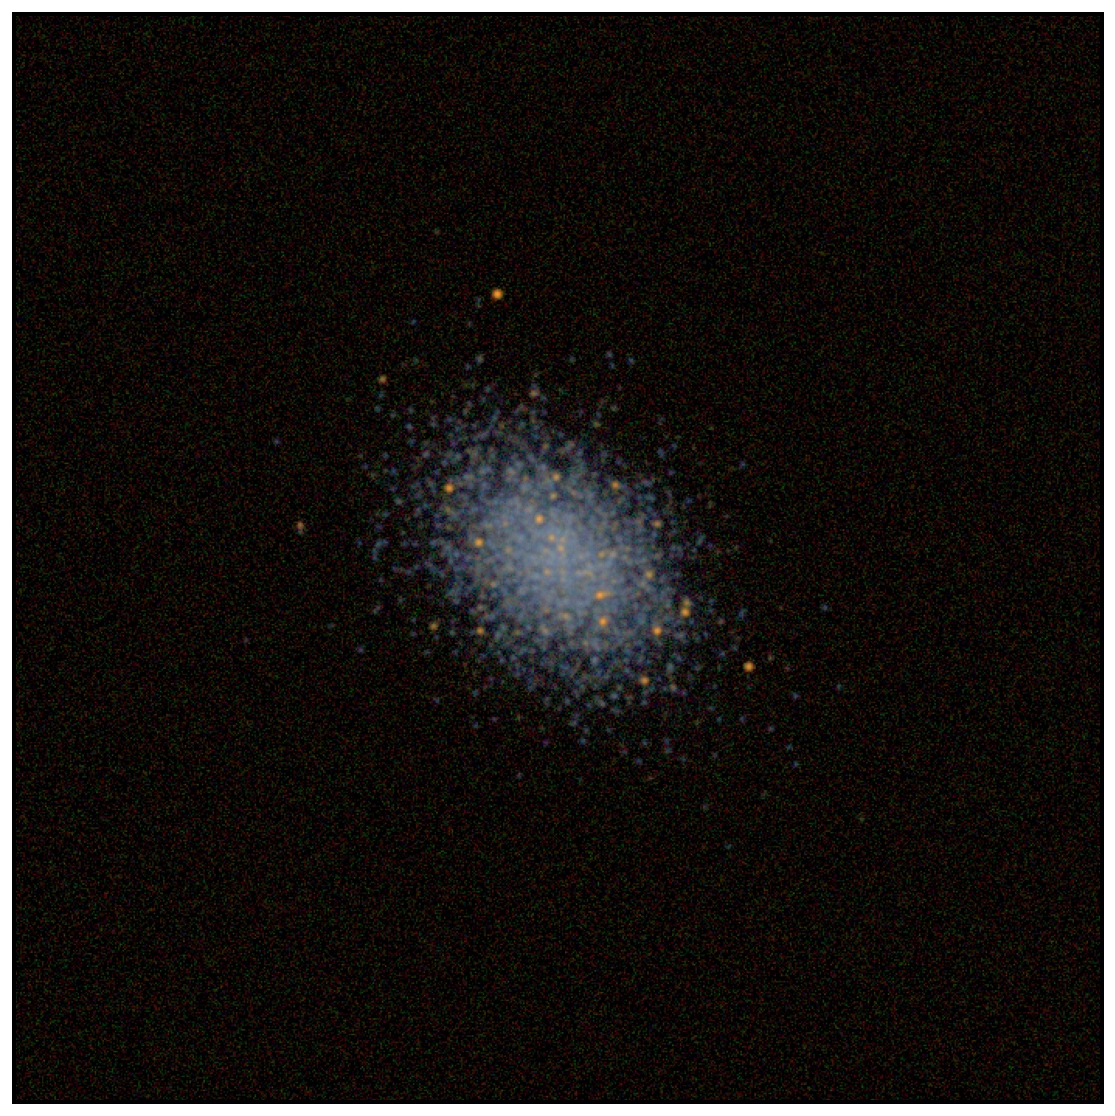

In [4]:
# PSF with 0.6'' seeing
psf = artpop.moffat_psf(fwhm=0.6*u.arcsec)

# observe in gri (assuming the same seeing in all bands)
obs_g = imager.observe(
    source = src,         # source object
    bandpass = 'LSST_g',  # bandpass of observation
    exptime = 15 * u.min, # exposure time 
    sky_sb = 22,          # sky surface brightness
    psf = psf             # point spread function 
)
obs_r = imager.observe(src, 'LSST_r', 15 * u.min, sky_sb=21, psf=psf)
obs_i = imager.observe(src, 'LSST_i', 30 * u.min, sky_sb=20, psf=psf)

rgb = make_lupton_rgb(obs_i.image, obs_r.image, obs_g.image, stretch=0.4)

artpop.show_image(rgb);